In [24]:
import os
import sys

import math
from datetime import timezone, datetime

import joblib
import lightgbm as lgb
import matplotlib.pyplot as plt
import mplfinance as mpf
import numba
import numpy as np
import pandas as pd
from scipy.stats import ttest_1samp
import seaborn as sns
import talib

from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import cross_val_score, KFold, TimeSeriesSplit

In [25]:
from timescaledb_util import TimeScaleDBUtil

_pg_config = {
        'user': os.environ['POSTGRES_USER'],
        'password': os.environ['POSTGRES_PASSWORD'],
        'host': os.environ['POSTGRES_HOST'],
        'port': os.environ['POSTGRES_PORT'],
        'database': os.environ['POSTGRES_DATABASE']
    }
    
_dbutil = TimeScaleDBUtil(user = _pg_config['user'], password = _pg_config['password'], host = _pg_config['host'], port = _pg_config['port'], database = _pg_config['database'])

In [26]:
df_dollar = _dbutil.read_sql_query(sql = "SELECT * FROM \"ftx_btc-perp_dollarbar_10000000\" ORDER BY dollar_cumsum ASC")
df_dollar = df_dollar[['datetime', 'datetime_from', 'open', 'high', 'low', 'close', 'dollar_volume', 'dollar_buy_volume', 'dollar_sell_volume', 'dollar_liquidation_buy_volume', 'dollar_liquidation_sell_volume', 'dollar_cumsum']]
df_dollar['fee'] = 0.02
df_dollar['delta_time'] = df_dollar['datetime'].diff()
df_dollar['dollar_buysell_ratio'] = df_dollar['dollar_buy_volume'] / df_dollar['dollar_sell_volume']
df_dollar = df_dollar[['datetime', 'open', 'high', 'low', 'close', 'dollar_volume', 'dollar_buy_volume', 'dollar_sell_volume', 'dollar_liquidation_buy_volume', 'dollar_liquidation_sell_volume', 'fee', 'delta_time']]
df_dollar = df_dollar.dropna()
df_dollar['delta_time'] = df_dollar['delta_time'].view(int) // 1_000_000 # 単位は秒
df_dollar.columns = ['Datetime', 'Open', 'High', 'Low', 'Close', 'dollar_volume', 'dollar_buy_volume', 'dollar_sell_volume', 'dollar_liquidation_buy_volume', 'dollar_liquidation_sell_volume', 'fee', 'Volume']
df_dollar = df_dollar.set_index("Datetime")
df_dollar.to_pickle('df_dollar_10000000_ohlcv.pkl')
df_dollar

,Open,High,Low,Close,dollar_volume,dollar_buy_volume,dollar_sell_volume,dollar_liquidation_buy_volume,dollar_liquidation_sell_volume,fee,Volume
Datetime,,,,,,,,,,,
2019-04-04 03:31:05.318000+00:00,4085.50,5314.00,4037.75,4996.25,1.002085e+07,5.897147e+06,4.123700e+06,0.00000,0.0000,0.02,530945155
2019-04-08 03:49:28.320000+00:00,4966.50,5309.50,4831.00,5232.25,9.863061e+06,5.547274e+06,4.315787e+06,0.00000,0.0000,0.02,346703002
2019-04-16 23:50:02.639000+00:00,5240.25,5457.25,4943.50,5216.00,9.967062e+06,6.460250e+06,3.506811e+06,0.00000,0.0000,0.02,763234319
2019-05-03 14:20:49.158000+00:00,5208.75,5791.50,5073.25,5756.00,1.017096e+07,4.921026e+06,5.249929e+06,0.00000,20667.5445,0.02,1434646519
2019-05-07 14:16:06.710000+00:00,5720.50,5958.50,5522.00,5831.50,9.973814e+06,6.035529e+06,3.938285e+06,269461.63550,30791.3320,0.02,345317552
...,...,...,...,...,...,...,...,...,...,...,...
2020-04-16 22:03:48.575000+00:00,7057.00,7141.50,7055.00,7129.50,1.000175e+07,7.161416e+06,2.840334e+06,1301.31660,0.0000,0.02,1702963
2020-04-16 22:28:13.924000+00:00,7129.50,7147.00,7066.00,7085.50,9.934665e+06,3.882685e+06,6.051981e+06,3255.69260,994.5145,0.02,1465349
2020-04-16 23:00:12.595000+00:00,7085.00,7189.00,7079.50,7180.00,1.006857e+07,6.955414e+06,3.113155e+06,13651.36075,38.7099,0.02,1918671


/tmp/ipykernel_3838825/226011884.py:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  mpf.plot(df_dollar['2020-03'], volume=True, figratio=(12, 6))
/opt/conda/lib/python3.9/site-packages/mplfinance/_arg_validators.py:35: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


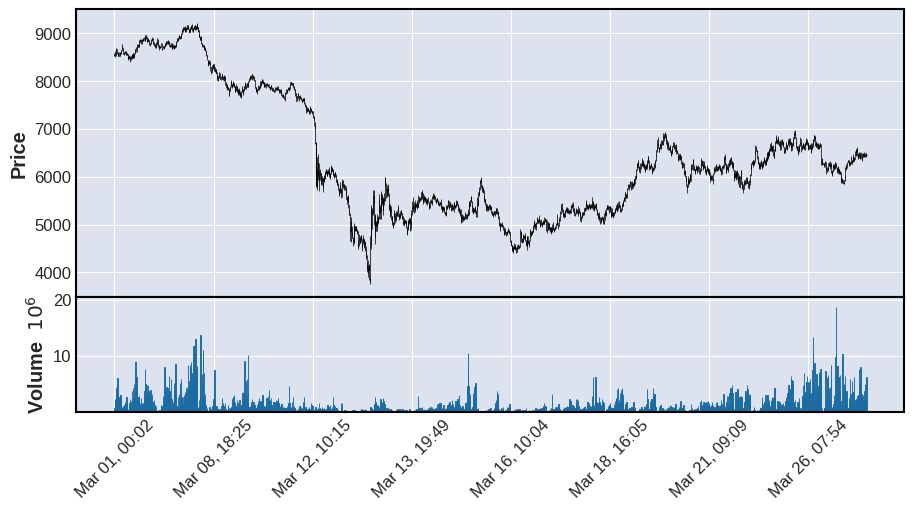

In [27]:
mpf.plot(df_dollar['2020-03'], volume=True, figratio=(12, 6))

In [28]:
def calc_features(df):
    open = df['Open']
    high = df['High']
    low = df['Low']
    close = df['Close']
    volume = df['dollar_buy_volume'] + df['dollar_sell_volume']
    liquidation = df['dollar_liquidation_buy_volume'] + df['dollar_liquidation_sell_volume']
    
    orig_columns = df.columns

    hilo = (high + low) / 2
    df['BBANDS_upperband'], df['BBANDS_middleband'], df['BBANDS_lowerband'] = talib.BBANDS(close, timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)
    df['BBANDS_upperband'] -= hilo
    df['BBANDS_middleband'] -= hilo
    df['BBANDS_lowerband'] -= hilo
    df['DEMA'] = talib.DEMA(close, timeperiod=30) - hilo
    df['EMA'] = talib.EMA(close, timeperiod=30) - hilo
    df['HT_TRENDLINE'] = talib.HT_TRENDLINE(close) - hilo
    df['KAMA'] = talib.KAMA(close, timeperiod=30) - hilo
    df['MA'] = talib.MA(close, timeperiod=30, matype=0) - hilo
    df['MIDPOINT'] = talib.MIDPOINT(close, timeperiod=14) - hilo
    df['SMA'] = talib.SMA(close, timeperiod=30) - hilo
    df['T3'] = talib.T3(close, timeperiod=5, vfactor=0) - hilo
    df['TEMA'] = talib.TEMA(close, timeperiod=30) - hilo
    df['TRIMA'] = talib.TRIMA(close, timeperiod=30) - hilo
    df['WMA'] = talib.WMA(close, timeperiod=30) - hilo

    df['ADX'] = talib.ADX(high, low, close, timeperiod=14)
    df['ADXR'] = talib.ADXR(high, low, close, timeperiod=14)
    df['APO'] = talib.APO(close, fastperiod=12, slowperiod=26, matype=0)
    df['AROON_aroondown'], df['AROON_aroonup'] = talib.AROON(high, low, timeperiod=14)
    df['AROONOSC'] = talib.AROONOSC(high, low, timeperiod=14)
    df['BOP'] = talib.BOP(open, high, low, close)
    df['CCI'] = talib.CCI(high, low, close, timeperiod=14)
    df['DX'] = talib.DX(high, low, close, timeperiod=14)
    df['MACD_macd'], df['MACD_macdsignal'], df['MACD_macdhist'] = talib.MACD(close, fastperiod=12, slowperiod=26, signalperiod=9)
    # skip MACDEXT MACDFIX たぶん同じなので
    df['MFI'] = talib.MFI(high, low, close, volume, timeperiod=14)
    df['MINUS_DI'] = talib.MINUS_DI(high, low, close, timeperiod=14)
    df['MINUS_DM'] = talib.MINUS_DM(high, low, timeperiod=14)
    df['MOM'] = talib.MOM(close, timeperiod=10)
    df['PLUS_DI'] = talib.PLUS_DI(high, low, close, timeperiod=14)
    df['PLUS_DM'] = talib.PLUS_DM(high, low, timeperiod=14)
    df['RSI'] = talib.RSI(close, timeperiod=14)
    df['STOCH_slowk'], df['STOCH_slowd'] = talib.STOCH(high, low, close, fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
    df['STOCHF_fastk'], df['STOCHF_fastd'] = talib.STOCHF(high, low, close, fastk_period=5, fastd_period=3, fastd_matype=0)
    df['STOCHRSI_fastk'], df['STOCHRSI_fastd'] = talib.STOCHRSI(close, timeperiod=14, fastk_period=5, fastd_period=3, fastd_matype=0)
    df['TRIX'] = talib.TRIX(close, timeperiod=30)
    df['ULTOSC'] = talib.ULTOSC(high, low, close, timeperiod1=7, timeperiod2=14, timeperiod3=28)
    df['WILLR'] = talib.WILLR(high, low, close, timeperiod=14)

    df['AD'] = talib.AD(high, low, close, volume)
    df['ADOSC'] = talib.ADOSC(high, low, close, volume, fastperiod=3, slowperiod=10)
    df['OBV'] = talib.OBV(close, volume)

    df['ATR'] = talib.ATR(high, low, close, timeperiod=14)
    df['NATR'] = talib.NATR(high, low, close, timeperiod=14)
    df['TRANGE'] = talib.TRANGE(high, low, close)

    df['HT_DCPERIOD'] = talib.HT_DCPERIOD(close)
    df['HT_DCPHASE'] = talib.HT_DCPHASE(close)
    df['HT_PHASOR_inphase'], df['HT_PHASOR_quadrature'] = talib.HT_PHASOR(close)
    df['HT_SINE_sine'], df['HT_SINE_leadsine'] = talib.HT_SINE(close)
    df['HT_TRENDMODE'] = talib.HT_TRENDMODE(close)

    df['BETA'] = talib.BETA(high, low, timeperiod=5)
    df['CORREL'] = talib.CORREL(high, low, timeperiod=30)
    df['LINEARREG'] = talib.LINEARREG(close, timeperiod=14) - close
    df['LINEARREG_ANGLE'] = talib.LINEARREG_ANGLE(close, timeperiod=14)
    df['LINEARREG_INTERCEPT'] = talib.LINEARREG_INTERCEPT(close, timeperiod=14) - close
    df['LINEARREG_SLOPE'] = talib.LINEARREG_SLOPE(close, timeperiod=14)
    df['STDDEV'] = talib.STDDEV(close, timeperiod=5, nbdev=1)

    return df

In [40]:
df_dollar = pd.read_pickle('df_dollar_10000000_ohlcv.pkl')
df_dollar = df_dollar.dropna()
df_dollar = calc_features(df_dollar)
df_dollar.to_pickle('df_dollar_10000000_ohlcv_features.pkl')

In [41]:
features = sorted([
    'ADX',
    'ADXR',
    'APO',
    'AROON_aroondown',
    'AROON_aroonup',
    'AROONOSC',
    'CCI',
    'DX',
    'MACD_macd',
    'MACD_macdsignal',
    'MACD_macdhist',
    'MFI',
#     'MINUS_DI',
#     'MINUS_DM',
    'MOM',
#     'PLUS_DI',
#     'PLUS_DM',
    'RSI',
    'STOCH_slowk',
    'STOCH_slowd',
    'STOCHF_fastk',
#     'STOCHRSI_fastd',
    'ULTOSC',
    'WILLR',
#     'ADOSC',
#     'NATR',
    'HT_DCPERIOD',
    'HT_DCPHASE',
    'HT_PHASOR_inphase',
    'HT_PHASOR_quadrature',
    'HT_TRENDMODE',
    'BETA',
    'LINEARREG',
    'LINEARREG_ANGLE',
    'LINEARREG_INTERCEPT',
    'LINEARREG_SLOPE',
    'STDDEV',
    'BBANDS_upperband',
    'BBANDS_middleband',
    'BBANDS_lowerband',
    'DEMA',
    'EMA',
    'HT_TRENDLINE',
    'KAMA',
    'MA',
    'MIDPOINT',
    'T3',
    'TEMA',
    'TRIMA',
    'WMA',
])

print(features)

['ADX', 'ADXR', 'APO', 'AROONOSC', 'AROON_aroondown', 'AROON_aroonup', 'BBANDS_lowerband', 'BBANDS_middleband', 'BBANDS_upperband', 'BETA', 'CCI', 'DEMA', 'DX', 'EMA', 'HT_DCPERIOD', 'HT_DCPHASE', 'HT_PHASOR_inphase', 'HT_PHASOR_quadrature', 'HT_TRENDLINE', 'HT_TRENDMODE', 'KAMA', 'LINEARREG', 'LINEARREG_ANGLE', 'LINEARREG_INTERCEPT', 'LINEARREG_SLOPE', 'MA', 'MACD_macd', 'MACD_macdhist', 'MACD_macdsignal', 'MFI', 'MIDPOINT', 'MOM', 'RSI', 'STDDEV', 'STOCHF_fastk', 'STOCH_slowd', 'STOCH_slowk', 'T3', 'TEMA', 'TRIMA', 'ULTOSC', 'WILLR', 'WMA']


In [42]:
@numba.njit
def calc_force_entry_price(entry_price=None, lo=None, pips=None):
    y = entry_price.copy()
    y[:] = np.nan
    force_entry_time = entry_price.copy()
    force_entry_time[:] = np.nan
    for i in range(entry_price.size):
        for j in range(i + 1, entry_price.size):
            if round(lo[j] / pips) < round(entry_price[j - 1] / pips):
                y[i] = entry_price[j - 1]
                force_entry_time[i] = j - i
                break
    return y, force_entry_time

In [43]:
def calc_buysell(df, pips = 1, atr_mux = 0.5):
    # ATRで指値距離を計算します
    df['ATR'] = talib.ATR(df['High'], df['Low'], df['Close'], timeperiod=14)
    limit_price_dist = df['ATR'] * atr_mux
    limit_price_dist = np.maximum(1, (limit_price_dist / pips).round().fillna(1)) * pips
    
    # 終値から両側にlimit_price_distだけ離れたところに、買い指値と売り指値を出します
    df['buy_price'] = df['Close'] - limit_price_dist
    df['sell_price'] = df['Close'] + limit_price_dist
    
    # Force Entry Priceの計算
    df['buy_fep'], df['buy_fet'] = calc_force_entry_price(
        entry_price=df['buy_price'].values,
        lo=df['Low'].values,
        pips=pips,
    )

    # calc_force_entry_priceは入力と出力をマイナスにすれば売りに使えます
    df['sell_fep'], df['sell_fet'] = calc_force_entry_price(
        entry_price=-df['sell_price'].values,
        lo=-df['High'].values, # 売りのときは高値
        pips=pips,
    )
    df['sell_fep'] *= -1
    
    horizon = 1 # エントリーしてからエグジットを始めるまでの待ち時間 (1以上である必要がある)
    fee = df['fee'] # maker手数料
    
    # 指値が約定したかどうか (0, 1)
    df['buy_executed'] = ((df['buy_price'] / pips).round() > (df['Low'].shift(-1) / pips).round()).astype('float64')
    df['sell_executed'] = ((df['sell_price'] / pips).round() < (df['High'].shift(-1) / pips).round()).astype('float64')
    
    # yを計算
    df['y_buy'] = np.where(
        df['buy_executed'],
        df['sell_fep'].shift(-horizon) / df['buy_price'] - 1 - 2 * fee,
        0
    )
    df['y_sell'] = np.where(
        df['sell_executed'],
        -(df['buy_fep'].shift(-horizon) / df['sell_price'] - 1) - 2 * fee,
        0
    )

    # バックテストで利用する取引コストを計算
    df['buy_cost'] = np.where(
        df['buy_executed'],
        df['buy_price'] / df['Close'] - 1 + fee,
        0
    )
    df['sell_cost'] = np.where(
        df['sell_executed'],
        -(df['sell_price'] / df['Close'] - 1) + fee,
        0
    )
    
    return df

In [74]:
df_dollar = pd.read_pickle('df_dollar_10000000_ohlcv_features.pkl')
df_dollar = calc_buysell(df_dollar, pips = 1, atr_mux = 0.5)
df_dollar.to_pickle('df_dollar_10000000_ohlcv_features_y.pkl')

約定確率を可視化。時期によって約定確率が大きく変わると良くない。
エグジットまでの時間分布を可視化。長すぎるとロングしているだけとかショートしているだけになるので良くない。
毎時刻、この執行方法でトレードした場合の累積リターン


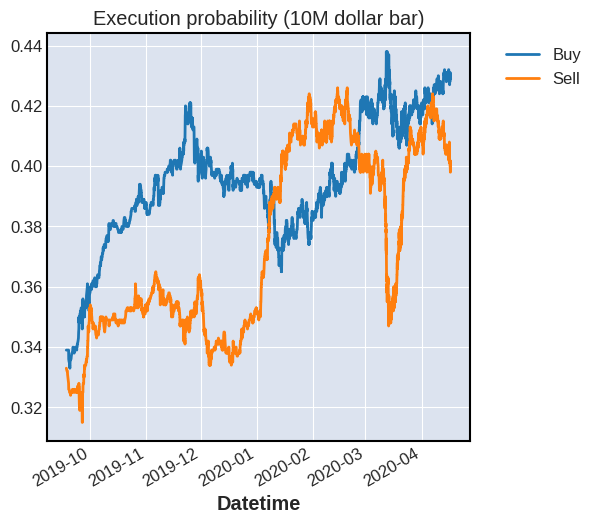

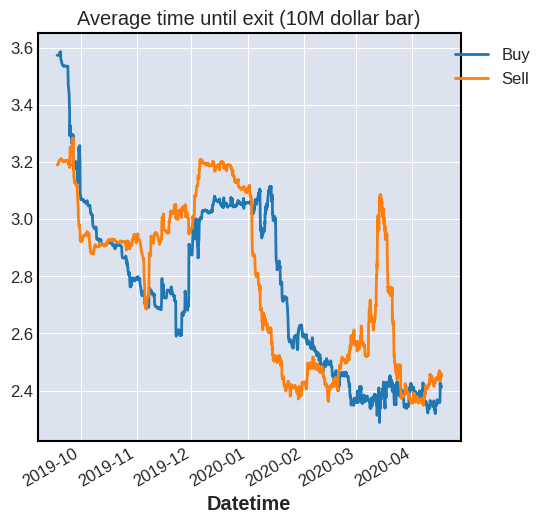

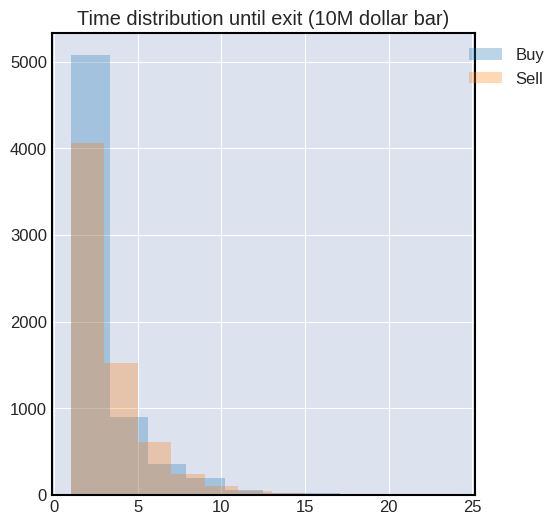

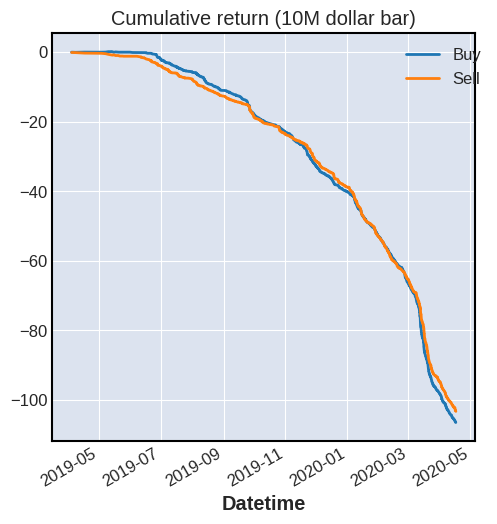

In [75]:
print('約定確率を可視化。時期によって約定確率が大きく変わると良くない。')
plt.figure(figsize=(12,6))
ax = plt.subplot(121)
df_dollar['buy_executed'].rolling(1000).mean().plot(label='Buy', ax=ax)
df_dollar['sell_executed'].rolling(1000).mean().plot(label='Sell', ax=ax)
plt.title('Execution probability (10M dollar bar)')
plt.legend(bbox_to_anchor=(1.05, 1))

print('エグジットまでの時間分布を可視化。長すぎるとロングしているだけとかショートしているだけになるので良くない。')
plt.figure(figsize=(12,6))
ax = plt.subplot(121)
df_dollar['buy_fet'].rolling(1000).mean().plot(label='Buy')
df_dollar['sell_fet'].rolling(1000).mean().plot(label='Sell')
plt.title('Average time until exit (10M dollar bar)')
plt.legend(bbox_to_anchor=(1.2, 1))

plt.figure(figsize=(12,6))
ax = plt.subplot(121)
df_dollar['buy_fet'].hist(alpha=0.3, label='Buy')
df_dollar['sell_fet'].hist(alpha=0.3, label='Sell')
plt.title('Time distribution until exit (10M dollar bar)')
plt.legend(bbox_to_anchor=(1.2, 1))

print('毎時刻、この執行方法でトレードした場合の累積リターン')
plt.figure(figsize=(12,6))
ax = plt.subplot(121)
df_dollar['y_buy'].cumsum().plot(label='Buy')
df_dollar['y_sell'].cumsum().plot(label='Sell')
plt.title('Cumulative return (10M dollar bar)')
plt.legend(bbox_to_anchor=(1.05, 1))

In [76]:
df_dollar_20 = pd.read_pickle('df_dollar_10000000_ohlcv_features.pkl')
df_dollar_20 = calc_buysell(df_dollar_20, pips = 1, atr_mux=2.0)

約定確率を可視化。時期によって約定確率が大きく変わると良くない。
エグジットまでの時間分布を可視化。長すぎるとロングしているだけとかショートしているだけになるので良くない。
毎時刻、この執行方法でトレードした場合の累積リターン


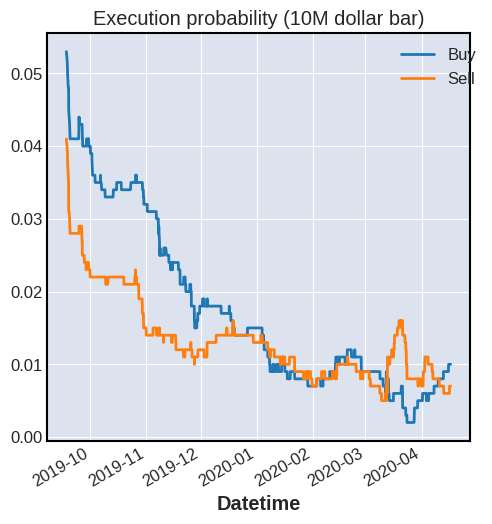

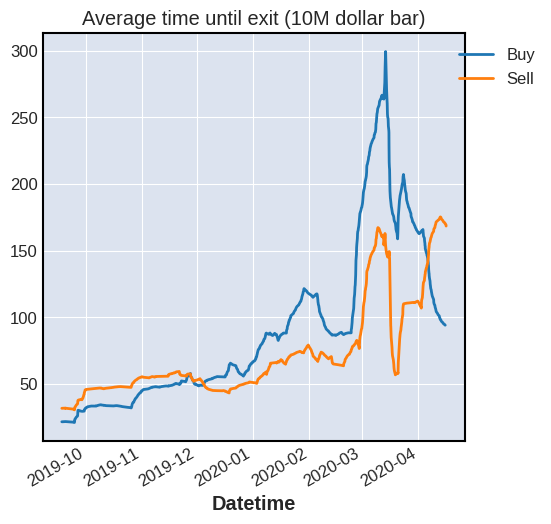

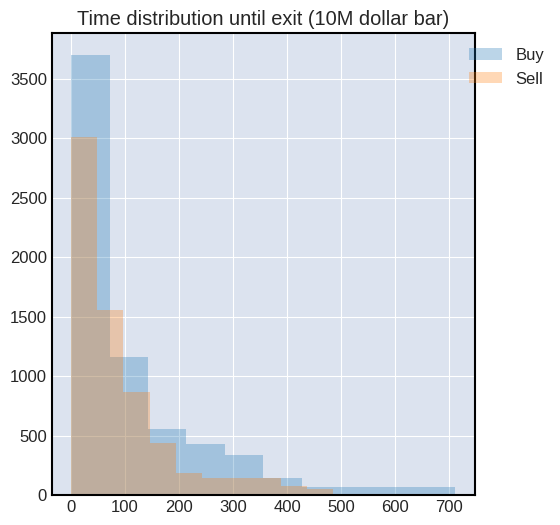

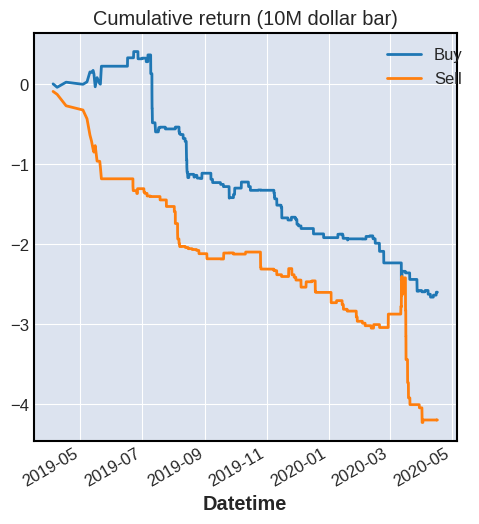

In [77]:
print('約定確率を可視化。時期によって約定確率が大きく変わると良くない。')
plt.figure(figsize=(12,6))
ax = plt.subplot(121)
df_dollar_20['buy_executed'].rolling(1000).mean().plot(label='Buy', ax=ax)
df_dollar_20['sell_executed'].rolling(1000).mean().plot(label='Sell', ax=ax)
plt.title('Execution probability (10M dollar bar)')
plt.legend(bbox_to_anchor=(1.05, 1))

print('エグジットまでの時間分布を可視化。長すぎるとロングしているだけとかショートしているだけになるので良くない。')
plt.figure(figsize=(12,6))
ax = plt.subplot(121)
df_dollar_20['buy_fet'].rolling(1000).mean().plot(label='Buy')
df_dollar_20['sell_fet'].rolling(1000).mean().plot(label='Sell')
plt.title('Average time until exit (10M dollar bar)')
plt.legend(bbox_to_anchor=(1.2, 1))

plt.figure(figsize=(12,6))
ax = plt.subplot(121)
df_dollar_20['buy_fet'].hist(alpha=0.3, label='Buy')
df_dollar_20['sell_fet'].hist(alpha=0.3, label='Sell')
plt.title('Time distribution until exit (10M dollar bar)')
plt.legend(bbox_to_anchor=(1.2, 1))

print('毎時刻、この執行方法でトレードした場合の累積リターン')
plt.figure(figsize=(12,6))
ax = plt.subplot(121)
df_dollar_20['y_buy'].cumsum().plot(label='Buy')
df_dollar_20['y_sell'].cumsum().plot(label='Sell')
plt.title('Cumulative return (10M dollar bar)')
plt.legend(bbox_to_anchor=(1.05, 1))

In [109]:
print(f'指値幅の係数 0.5 : バーの数 {len(df_dollar)}本, 買い {len(df_dollar[(df_dollar["buy_executed"]==1.0)])}回, 売り {len(df_dollar[(df_dollar["sell_executed"]==1.0)])}回, 買った時のリターン平均 {df_dollar["y_buy"].mean()*100:.03f} %, 売った時のリターン平均 {df_dollar["y_sell"].mean()*100:.03f} %')
print(f'指値幅の係数 0.5 : リターンが0以上になる率 {(len(df_dollar[df_dollar["y_buy"] > 0]) + len(df_dollar[df_dollar["y_sell"] > 0])) / (len(df_dollar[(df_dollar["buy_executed"]==1.0)]) + len(df_dollar[(df_dollar["sell_executed"]==1.0)])) * 100} %')
print(f'指値幅の係数 2.0 : バーの数 {len(df_dollar_20)}本, 買い {len(df_dollar_20[(df_dollar_20["buy_executed"]==1.0)])}回, 売り {len(df_dollar_20[(df_dollar_20["sell_executed"]==1.0)])}回, 買った時のリターン平均 {df_dollar_20["y_buy"].mean()*100:.03f} %, 売った時のリターン平均 {df_dollar_20["y_sell"].mean()*100:.03f} %')
print(f'指値幅の係数 2.0 : リターンが0以上になる率 {(len(df_dollar_20[df_dollar_20["y_buy"] > 0]) + len(df_dollar_20[df_dollar_20["y_sell"] > 0])) / (len(df_dollar_20[(df_dollar_20["buy_executed"]==1.0)]) + len(df_dollar_20[(df_dollar_20["sell_executed"]==1.0)])) * 100} %')

指値幅の係数 0.5 : バーの数 6651本, 買い 2649回, 売り 2521回, 買った時のリターン平均 -1.602 %, 売った時のリターン平均 -1.554 %
指値幅の係数 0.5 : リターンが0以上になる率 0.7736943907156674 %
指値幅の係数 2.0 : バーの数 6651本, 買い 111回, 売り 98回, 買った時のリターン平均 -0.039 %, 売った時のリターン平均 -0.063 %
指値幅の係数 2.0 : リターンが0以上になる率 28.22966507177033 %
